In [48]:
# Load the "autoreload" extension so that code can change
# Always reload modules so that as soon as code changes in src, it gets automatically reloaded without kernel relaunch
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import sys
sys.path.append('../') 

from src.utils import datacollector
from src.utils import constants as cst

from src.visualization import visualization as viz
from src.preprocessing import cleaning

# REMINDER - OBJECTIVE
As a reminder, **our objective for modeling will be to be able to predict the price for a given listing**.  
We have seen that the price can be rather different depending on the period of the year. Of course, it can varies due to some other features, each one with its own importance. We have observed for example that the neighbourhood is one of them.  
To build something which will more reflect what happens in real life, I should merge the `listings.csv.gz` dataset with the `calendar.csv.gz` one but it will give me a too huge dataset with more than 20 millions of rows and hundred of features.  
**For computation reasons and as the goal of this project is more to validate an approach than building the perfectly perfect model, I choose to keep only the `listings.csv.gz` dataset and its 64K rows and my goal will be to try to predict the mean price for each element of the listing**.

In next sections below you will find all preliminary steps that are mandatory before starting the modeling phase.  
This will be based on what we have discovered during the [Data Understanding](1_Data_Understanding.ipynb) phase (see the 'summary' part for a reminder).

# 1. Load dataset & drop unnecessary features
The easiest thing to start with.

In [2]:
df_lst_full = pd.read_csv(datacollector.get_data_file(cst.LISTING_FULL_FILE), sep=',', header=0, low_memory=False)

In [3]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 'notes', 'transit', 'interaction', 
                'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_name', 
                'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_since', 
                'host_location', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 
                'host_verifications', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic', 
                'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
                'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'street', 
                'neighbourhood', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 
                'country_code', 'country', 'latitude', 'longitude', 'property_type', 'square_feet', 'has_availability', 
                'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review', 'requires_license', 
                'is_business_travel_ready', 'require_guest_profile_picture', 'require_guest_phone_verification']
df_lst_reduced = cleaning.drop_cols(df_lst_full, cols_to_drop)

After column dropping, new shape is now (64293, 51)


# 2. Features transformation
## 2.1. Text extraction or drop ?
I said in [Data Understanding](1_Data_Understanding.ipynb) conclusion that depending on the use case, perhaps we could try to extract some keywords from `name`, `summary`, `space`, `description`, `neighborhood_overview`, `access`.  
Idea is good and could be addressed with NLP packages, maint thing is those features contains text which is sometimes in french sometimes in english. That would add a non negligible amount of data so, for the moment, I propose to start with a simple approach and just drop those features.

In [4]:
txt_cols_to_drop = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'access']
df_lst_reduced_notxt = cleaning.drop_cols(df_lst_reduced, txt_cols_to_drop)

After column dropping, new shape is now (64293, 45)


## 2.2. From 't'/'f' to binary 0/1
Here we will deal with columns that contains the now famous "t/f" categorical nominal values.

In [5]:
tf_cols = ['host_is_superhost', 'host_identity_verified', 'is_location_exact', 'instant_bookable']

# Keep track of values before transformation so that we can check after that everything went as expected
check_dict = {}

# Transform each column and control
for feat in tf_cols:
    check_dict[feat] = df_lst_reduced_notxt[df_lst_reduced_notxt[feat] == 't'][feat].count()
    df_lst_reduced_notxt = cleaning.transform_t_f(df_lst_reduced_notxt, feat)
    
    assert check_dict[feat] == df_lst_reduced_notxt[feat].sum()
print("After transformation shape is still {}".format(df_lst_reduced_notxt.shape))

After transformation shape is still (64293, 45)


**Note:** the transformation for those features is not totally finished, **we will still have to handle missing values for some of them:**

In [6]:
for feat in tf_cols:
    print("Nb missing values for feature '{}' is {}".format(feat, df_lst_reduced_notxt[feat].isna().sum()))

Nb missing values for feature 'host_is_superhost' is 64
Nb missing values for feature 'host_identity_verified' is 64
Nb missing values for feature 'is_location_exact' is 0
Nb missing values for feature 'instant_bookable' is 0


We have also the `license` feature to deal with. It is not a "t/f" column but after the _data discovery_ phase the decision was to create a new binary feature which will stand for 'license missing yes/no'. Let's do that.

In [7]:
df_lst_reduced_notxt['license_missing'] = df_lst_reduced_notxt['license'].apply(lambda x: 1 if pd.isnull(x) else 0)
assert df_lst_reduced_notxt['license_missing'].sum() == df_lst_reduced_notxt['license'].isna().sum()
# Do not forget to remove the old column which is now useless
df_lst_reduced_notxt = cleaning.drop_cols(df_lst_reduced_notxt, ['license'])

After column dropping, new shape is now (64293, 45)


## 2.3. Handle 'currency' columns
For columns with 'currency' elements ('price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people') we will remove currency symbol and handle the thousands separator. In the end we convert to float.

In [8]:
currency_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
df_lst_reduced_notxt_currok = cleaning.clean_currency_columns(df_lst_reduced_notxt, currency_cols)

In [9]:
for feat in currency_cols:
    print("Nb missing values for feature '{}' is {}".format(feat, df_lst_reduced_notxt_currok[feat].isna().sum()))

Nb missing values for feature 'price' is 0
Nb missing values for feature 'weekly_price' is 53899
Nb missing values for feature 'monthly_price' is 57694
Nb missing values for feature 'security_deposit' is 19852
Nb missing values for feature 'cleaning_fee' is 17191
Nb missing values for feature 'extra_people' is 0


After new considerations **regarding the number of missing values I decide to also drop `weekly_price` and `monthly_price`**.  With very few missing values, perhaps it would have helped us to predict a mean price but here imputation will lead us with really strange results so I prefer to get rid of those features. I should have seen that before but late is better than never so...  
`cleaning_fee` and `security_deposit` will have to be handled later with kind of imputation.

In [10]:
df_lst_reduced_notxt_currok = cleaning.drop_cols(df_lst_reduced_notxt_currok, ['weekly_price', 'monthly_price'])

After column dropping, new shape is now (64293, 43)


## 2.4. One-hot encoding of categorical features
`neighbourhood_cleansed`, `room_type`, `bed_type` and `cancellation_policy` are the features chosen for this kind of transformation.

In [11]:
one_hot_cols = ['neighbourhood_cleansed', 'room_type', 'bed_type', 'cancellation_policy']
for feat in one_hot_cols:
    print("Nb missing values for feature '{}' is {}".format(feat, df_lst_reduced_notxt_currok[feat].isna().sum()))
df_lst_reduced_notxt_currok_dummies = cleaning.encode_categorical(df_lst_reduced_notxt_currok, one_hot_cols)

Nb missing values for feature 'neighbourhood_cleansed' is 0
Nb missing values for feature 'room_type' is 0
Nb missing values for feature 'bed_type' is 0
Nb missing values for feature 'cancellation_policy' is 1
After one-hot encoding, new shape is now (64293, 73)


## 2.5 Handle 'jurisdiction_names' feature

In [12]:
df_lst_reduced_notxt_currok_dummies.jurisdiction_names.value_counts()

{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," PARIS"}                                                                           62850
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"}                                                                                      767
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," BOULOGNE BILLANCOURT"}                                                               77
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," NEUILLY SUR SEINE"}                                                                  55
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," ISSY LES MOULINEAUX"}                                                                52
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_"," LEVALLOIS PERRET"}                                                                   50
{"translation missing: en.occupancy.taxes.jurisdiction.names.FR_

All well considered, after transformation 98% of the dataset will have _'Paris'_ as value. The 2nd value will be something like _'None'_ (767 rows) so it will not help us. **In the end I choose to drop this feature.**

In [13]:
df_lst_reduced_notxt_currok_dummies = cleaning.drop_cols(df_lst_reduced_notxt_currok_dummies, ['jurisdiction_names'])

After column dropping, new shape is now (64293, 72)


## 2.6 Last but not least, 'amenities' management
For this feature we will extract useful information and depending on the number of distinct values, perform 1-hot encoding over the values

In [14]:
df_lst_reduced_notxt_currok_dummies.amenities.value_counts()[:10]

{}                                                                                                                                                                                 181
{TV,"Cable TV",Wifi,Kitchen,Heating,"Family/kid friendly",Washer,"Smoke detector",Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}                                            52
{TV,Wifi,Kitchen,Heating,Washer,"Smoke detector",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Private entrance","Hot water","Bed linens"}              34
{Internet,Wifi,Kitchen,Heating,Essentials}                                                                                                                                          31
{TV,Wifi,Kitchen,Elevator,Heating,Washer,"Smoke detector",Essentials,Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}                                                         28
{Internet,Wifi,Kitchen,Heating,Washer,Essentials}                                    

In [15]:
df_lst_reduced_notxt_currok_dummies.amenities.isna().sum()

0

Good point is that **there is no missing value** (actually they are _replaced_ with '{}'). Now I will remove the leading '{' and '}' characters. And remove also the '"' punctuation.  
I will then handle the multiple values transformation to dummies with this [helpful link from stackoverflow](https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas).

In [16]:
df_lst_reduced_notxt_currok_dummies.amenities = df_lst_reduced_notxt_currok_dummies.amenities.str.strip('{}')
df_lst_reduced_notxt_currok_dummies.amenities = df_lst_reduced_notxt_currok_dummies.amenities.str.replace('"', '')

In [22]:
df_only_amenities = df_lst_reduced_notxt_currok_dummies.amenities
df_only_amenities = df_only_amenities.str.get_dummies(sep=',')

In [23]:
df_only_amenities.head()

,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,Alfresco bathtub,Amazon Echo,BBQ grill,Baby bath,...,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cooler,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Wow 182 columns that's a lot !  
**Notes:**
* there are at least 2 translations missing, will it matter ?
* in what has been transformed the empty initial amenities value '{}' ?

In [21]:
print(df_only_amenities.columns.tolist(), end='')

[' toilet', '24-hour check-in', 'Accessible-height bed', 'Accessible-height toilet', 'Air conditioning', 'Air purifier', 'Alfresco bathtub', 'Amazon Echo', 'BBQ grill', 'Baby bath', 'Baby monitor', 'Babysitter recommendations', 'Balcony', 'Bath towel', 'Bathroom essentials', 'Bathtub', 'Bathtub with bath chair', 'Beach essentials', 'Beach view', 'Beachfront', 'Bed linens', 'Bedroom comforts', 'Bidet', 'Body soap', 'Breakfast', 'Breakfast table', 'Building staff', 'Buzzer/wireless intercom', 'Cable TV', 'Carbon monoxide detector', 'Cat(s)', 'Ceiling fan', 'Ceiling hoist', 'Central air conditioning', 'Changing table', 'Children’s books and toys', 'Children’s dinnerware', 'Cleaning before checkout', 'Coffee maker', 'Convection oven', 'Cooking basics', 'Crib', 'DVD player', 'Day bed', 'Disabled parking spot', 'Dishes and silverware', 'Dishwasher', 'Dog(s)', 'Doorman', 'Double oven', 'Dryer', 'EV charger', 'Electric profiling bed', 'Elevator', 'En suite bathroom', 'Espresso machine', 'Essen

As 182 new columns is a lot, I will check if there are amenities with few occurrences.

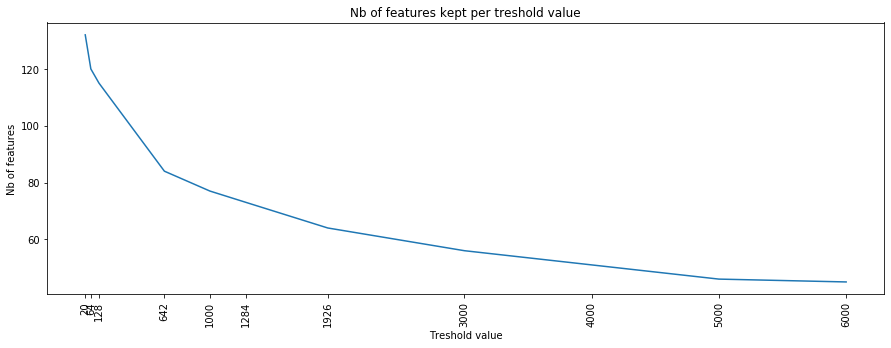

In [52]:
df_amen_sum = viz.plot_amenities_nb_features_and_tresholds(df_only_amenities)

Here we are not choosing the number of clusters with 'elbow' method but the approach is similar: ***we are looking for a specific value (threshold) that would reduce our number of new amenities features in a smart way***. For that we count the number of listings containing each amenity and we plot the number of features that would be kept if the treshold were this or this value.  
For instance, here we can see that **with a treshold of 642 we keep around 80 features, that's almost 100 less !**  
Note that 642 in this case represents 1% of the total number of listings so it's not bad at all: dropping the more or less 100 hundred features would impact less than 1% of the listings. The more we increase the treshold value the less we 'gain' in feature dropping (it is around 70 features for 2%). Let's keep the 1%.

In [57]:
# Let's see what it looks like
df_amen_sum[df_amen_sum['amen_sum'] < 642].head(7)

,amen_sum
toilet,346
Accessible-height bed,257
Accessible-height toilet,221
Air purifier,3
Alfresco bathtub,1
Amazon Echo,3
BBQ grill,225


In [62]:
df_only_amenities_reduced = cleaning.drop_cols(df_only_amenities, df_amen_sum[df_amen_sum['amen_sum'] < 642].index.tolist())

After column dropping, new shape is now (64293, 84)


In [64]:
# We're almost there, just concat and drop the original 'amenities' column
df_almost_clean = pd.concat([df_lst_reduced_notxt_currok_dummies, df_only_amenities_reduced], axis=1)
assert df_almost_clean.shape[1] == df_lst_reduced_notxt_currok_dummies.shape[1] + df_only_amenities_reduced.shape[1]
assert df_almost_clean.shape[0] == df_lst_reduced_notxt_currok_dummies.shape[0]
df_almost_clean = cleaning.drop_cols(df_almost_clean, ['amenities'])

After column dropping, new shape is now (64293, 155)


## 2.7. So now we can handle rows with missing values

In [68]:
df_almost_clean.isna().sum(axis=1).sort_values(ascending=False)

41055    13
41054    13
6577     13
14742    12
11931    12
         ..
48809     0
48810     0
48811     0
27823     0
0         0
Length: 64293, dtype: int64

In [71]:
df_almost_clean.isna().sum().sort_values(ascending=False)

security_deposit               19852
cleaning_fee                   17191
review_scores_checkin          15831
review_scores_value            15830
review_scores_location         15829
                               ...  
Free parking on premises           0
Flat path to guest entrance        0
First aid kit                      0
Fire extinguisher                  0
id                                 0
Length: 155, dtype: int64

In [74]:
df_almost_clean.isna().any()

id                                            False
host_is_superhost                              True
host_identity_verified                         True
is_location_exact                             False
accommodates                                  False
                                              ...  
Wide entryway                                 False
Wide hallways                                 False
Wifi                                          False
translation missing: en.hosting_amenity_49    False
translation missing: en.hosting_amenity_50    False
Length: 155, dtype: bool